# Imports and Functions

In [1]:
from sunlab.environment.base.cuda import *
from sunlab.environment.base.extras import *
from sunlab.globals import FILES
from sunlab.sunflow import *

In [2]:
from sunlab.sunflow.models_elu import AdversarialAutoencoder as AdversarialAutoencoderELU

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

# Setup

## Model

In [5]:
try:
    del model
except:
    pass

In [ ]:
_D = 1

In [75]:
dataset_file_name = FILES['TRAINING_DATASET']
test_dataset_files = [FILES['SPHEROID']['3mgml'],FILES['SPHEROID']['4mgml'],FILES['SPHEROID']['6mgml']]
model_directory = "../../test_models/autoencoder/"
normalization_scaler = MaxAbsScaler
distribution = [SwissRollDistribution,UniformDistribution,XGaussianDistribution][_D]
magnification = 10
latent_size = 2
batch_size = 1024
shuffle=True
val_split=0.1
autoencoder_depth = 3
use_leaky_relu = False
equal_split = True

In [76]:
dataset = import_dataset(dataset_file_name, magnification)
model = AdversarialAutoencoder(
    model_directory, distribution, normalization_scaler
).init(dataset.dataset, latent_size=latent_size, autoencoder_depth=autoencoder_depth, use_leaky_relu=False)
dataset = ShapeDataset(
    dataset_file_name,
    pre_scale=magnification,
    batch_size=batch_size,
    shuffle=shuffle,
    val_split=val_split,
    scaler=model.scaler,
    sort_columns=None,
    equal_split=equal_split,
)

In [77]:
test_datasets = [import_dataset(dataset, magnification, scaler=model.scaler) for dataset in test_dataset_files]
test_dataset = np.vstack([test_dataset.dataset for test_dataset in test_datasets])

In [78]:
test_dataset.shape

(13411, 13)

# Runtime Parameters

In [79]:
SAVE_EXTRAS = False

# Results

In [80]:
classification_dataset_dict = np.load(DIR_ROOT + "extra_data/ClassificationTestingDataset.npy", allow_pickle=True).item()
classification_dataset = classification_dataset_dict['normalized_dataset']

In [81]:
dataset = import_dataset(dataset_file_name, magnification)
model = AdversarialAutoencoder(
    model_directory, distribution, normalization_scaler
).init(dataset.dataset, latent_size=latent_size, autoencoder_depth=autoencoder_depth, use_leaky_relu=False)
dataset = ShapeDataset(
    dataset_file_name,
    pre_scale=magnification,
    batch_size=batch_size,
    shuffle=shuffle,
    val_split=val_split,
    scaler=model.scaler,
    sort_columns=None,
    equal_split=equal_split,
)
training_dataset = model.scaler(dataset.training_data.copy())
validation_dataset = model.scaler(dataset.validation_data.copy())

In [82]:
training_dataset.shape, validation_dataset.shape

((11712, 13), (7767, 13))

In [83]:
dataScaler = model.scaler.scaler

In [84]:
training_data = []
training_classification_data = []

In [85]:
from tqdm.auto import tqdm

In [86]:
from itertools import product
import timeit
epochs = 1600
relu_type = 1
autoencoder_depth = 2
timeit.default_timer()
if relu_type == 0:
    # ReLU
    model = AdversarialAutoencoder(
        model_directory, distribution, normalization_scaler
    ).init(dataset.dataset, latent_size=latent_size, autoencoder_depth=autoencoder_depth, use_leaky_relu=False)
elif relu_type == 1:
    # LeakyReLU
    model = AdversarialAutoencoder(
        model_directory, distribution, normalization_scaler
    ).init(dataset.dataset, latent_size=latent_size, autoencoder_depth=autoencoder_depth, use_leaky_relu=True)
elif relu_type == 2:
    # ELU
    model = AdversarialAutoencoderELU(
        model_directory[:-1] + f"_{autoencoder_depth}_{relu_type}_{epochs}_{n_tests}", distribution, normalization_scaler
    ).init(dataset.dataset, latent_size=latent_size, autoencoder_depth=autoencoder_depth, use_leaky_relu=False)
start_time = timeit.default_timer()
_ = model.train(dataset, epochs, output=True, output_freq=100)
elapsed_train = timeit.default_timer() - start_time
start_time = timeit.default_timer()
run_this = model.encoder(dataset.dataset).numpy()
elapsed_inference = timeit.default_timer() - start_time
ae_t = np.abs(model.autoencoder(training_dataset).numpy() - training_dataset)
ae_v = np.abs(model.autoencoder(validation_dataset).numpy() - validation_dataset)
ae_T = np.abs(model.autoencoder(test_dataset).numpy() - test_dataset)
mae_t = np.mean(ae_t)
mae_v = np.mean(ae_v)
mae_T = np.mean(ae_T)
rmse_t = np.mean((np.mean(ae_t ** 2., axis=-1)) ** (1./2.))
rmse_v = np.mean((np.mean(ae_v ** 2., axis=-1)) ** (1./2.))
rmse_T = np.mean((np.mean(ae_T ** 2., axis=-1)) ** (1./2.))
rmpe_t = np.mean((np.mean(ae_t ** 13., axis=-1)) ** (1./13.))
rmpe_v = np.mean((np.mean(ae_v ** 13., axis=-1)) ** (1./13.))
rmpe_T = np.mean((np.mean(ae_T ** 13., axis=-1)) ** (1./13.))
training_data.append((relu_type, autoencoder_depth, epochs, elapsed_train, elapsed_inference,
             mae_t, mae_v, mae_T,
             rmse_t, rmse_v, rmse_T,
             rmpe_t, rmpe_v, rmpe_T))
training_classification_data.append(
    dataScaler.inverse_transform((model.autoencoder(classification_dataset).numpy()))
)

0[nan]: 2.70e-01 6.61e-01 8.01e-01  nan nan nan
100[0.062]: 1.00e-01 6.99e-01 6.83e-01  1.06e-01 6.98e-01 6.84e-01
200[0.071]: 7.43e-02 6.94e-01 7.05e-01  7.64e-02 6.94e-01 7.05e-01
300[0.067]: 6.06e-02 6.91e-01 6.94e-01  6.40e-02 6.92e-01 6.91e-01
400[0.068]: 4.50e-02 6.94e-01 6.92e-01  4.60e-02 6.96e-01 6.87e-01
500[0.071]: 3.91e-02 7.07e-01 6.90e-01  3.86e-02 7.11e-01 6.83e-01
600[0.068]: 2.91e-02 6.81e-01 7.08e-01  2.93e-02 6.81e-01 7.08e-01
700[0.069]: 2.81e-02 6.90e-01 6.90e-01  2.82e-02 6.95e-01 6.78e-01
800[0.066]: 2.80e-02 6.70e-01 7.05e-01  2.85e-02 6.75e-01 6.92e-01
900[0.082]: 2.78e-02 6.94e-01 6.79e-01  3.01e-02 7.02e-01 6.61e-01
1000[0.063]: 2.65e-02 6.86e-01 7.17e-01  2.60e-02 6.85e-01 7.19e-01
1100[0.065]: 2.56e-02 6.93e-01 6.92e-01  2.55e-02 6.94e-01 6.89e-01
1200[0.062]: 2.58e-02 6.91e-01 7.01e-01  2.70e-02 6.91e-01 7.00e-01
1300[0.066]: 2.50e-02 6.98e-01 6.96e-01  2.50e-02 6.99e-01 6.93e-01
1400[0.067]: 2.51e-02 6.84e-01 7.00e-01  2.46e-02 6.87e-01 6.96e-01
1500[0.06

In [87]:
model.distribution.get_name()

'U'

In [88]:
np.mean(np.abs(dataset.dataset - model.autoencoder(dataset.dataset).numpy()))

0.023982168128480114

<module 'matplotlib.pyplot' from '/home/physics/cunnichr/.conda/envs/tfnb/lib/python3.9/site-packages/matplotlib/pyplot.py'>

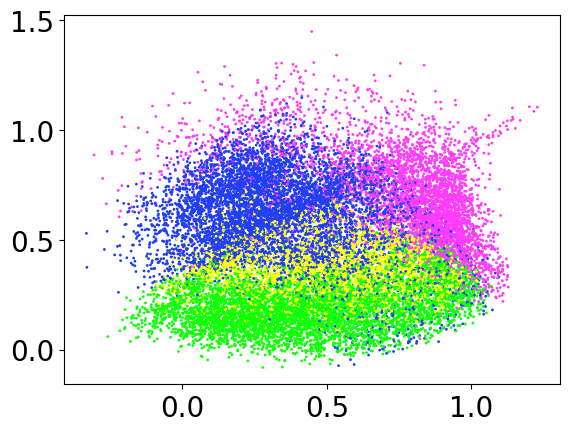

In [89]:
plt.scatter2d(model.encoder(dataset.dataset).numpy(), c=dataset.labels, s=1, cmap=Pmap)
if SAVE_EXTRAS:
    plt.save(f"../Figures/OtherDists/{model.distribution.get_name()}")